In [ ]:
!pip install cpprb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 20.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from cpprb import ReplayBuffer
import time
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

## 1, We define two classes: Actor and Critic.   
These classes are used in reinforcement learning with the Deep Deterministic Policy Gradient (DDPG) algorithm for predicting the price of an option.

The Actor class defines a policy function that maps the state of the environment to an action. The __init__ method initializes the neural network layers for the policy function. It takes in the state_shape of the environment, the action_dim for the dimension of the action space, and the max_action that represents the maximum value an action can take. The super().__init__ method initializes the superclass tf.keras.Model.  

The l1, l2, and l3 are three layers of the neural network defined using tf.keras.layers.Dense. l1 and l2 are fully connected layers with 300 and 200 units respectively and ReLU activation function. l3 is another fully connected layer with action_dim units and hyperbolic tangent (tanh) activation function. The max_action value is stored for scaling the output of the policy function.  

The Critic class defines a Q-function that maps the state-action pair to a Q-value, which represents the expected return from taking that action in that state. The __init__ method initializes the neural network layers for the Q-function. It takes in the state_shape of the environment, the action_dim for the dimension of the action space. The super().__init__ method initializes the superclass tf.keras.Model.  



In [ ]:
class Actor(tf.keras.Model):
  '''Policy'''
  def __init__(self, state_shape, action_dim, max_action, name='Actor'):
    super().__init__(name=name)

    self.l1 = Dense(300, name='L1', activation='relu')
    self.l2 = Dense(200, name='L2', activation='relu')
    self.l3 = Dense(action_dim, name='L3', activation='tanh')

    self.max_action = max_action

    # Build model
    self(tf.constant(np.zeros(shape=(1,)+state_shape, dtype=np.float32))) 
  
  def call(self, inputs):
    features = self.l1(inputs)
    features = self.l2(features)
    features = self.l3(features)
    action = self.max_action * features
    return action
class Critic(tf.keras.Model):
  '''Q-function'''
  def __init__(self, state_shape, action_dim, name='Critic'):
    super().__init__(name=name)

    self.l1 = Dense(300, name='L1', activation='relu')
    self.l2 = Dense(200, name='L2', activation='relu')
    self.l3 = Dense(1, name='L3')

    # Build model
    dummy_state = tf.constant(np.zeros(shape=(1,)+state_shape, dtype=np.float32))
    dummy_action = tf.constant(np.zeros(shape=(1,action_dim), dtype=np.float32))
    self([dummy_state, dummy_action])

  def call(self, inputs):
    states, actions = inputs
    features = tf.concat([states, actions], axis=1)
    features = self.l1(features)
    features = self.l2(features)
    features = self.l3(features)
    return features 

### Methods:  
The call method is defined to execute the forward pass through the neural network. It takes inputs as input, which is a tensor representing the state of the environment. The tensor is fed into the l1, l2, and l3 layers sequentially. The output of the l3 layer is then multiplied by max_action to scale the output to the appropriate range of the action space. Finally, the action tensor is returned as output.    

The l1, l2, and l3 are three layers of the neural network defined using tf.keras.layers.Dense. l1 and l2 are fully connected layers with 300 and 200 units respectively and ReLU activation function. l3 is another fully connected layer with 1 unit. The call method is defined to execute the forward pass through the neural network. The output of the l3 layer represents the Q-value for the given state-action pair and is returned as output.

## 2, Modelling

In [ ]:
class DDPG(tf.keras.Model):
  def __init__(self, 
               state_shape, 
               action_dim, 
               name='DDPG', 
               max_action=1, 
               lr_actor=1e-3, 
               lr_critic=1e-3, 
               sigma=.1, 
               tau=5e-3,
               n_warmup=int(1e4), 
               memory_capacity=int(1e6),
               gamma = 1.,
               huber_loss_delta=10.):
    super().__init__(name=name)
    self.memory_capacity = memory_capacity
    self.n_warmup = n_warmup

    # Define and initialize Actor network
    self.actor = Actor(state_shape, action_dim, max_action)
    self.actor_target = Actor(state_shape, action_dim, max_action)
    self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_actor)
    self.update_target_variables(self.actor_target.weights, self.actor.weights, tau=1.)

    # Define and initialize Critic network
    self.critic = Critic(state_shape, action_dim)
    self.critic_target = Critic(state_shape, action_dim)
    self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_critic)
    self.update_target_variables(self.critic_target.weights, self.critic.weights, tau=1.)

    # Hyperparameters
    self.sigma = sigma  # Explore level
    self.gamma = gamma
    self.tau = tau
    self.huber_loss_delta = huber_loss_delta

  def get_action(self, state, test=False):
    is_single_state = len(state.shape) == 1
    if is_single_state:
      state = np.expand_dims(state, axis=0).astype(np.float32)
      # state = state[:,np.newaxis].astype(np.float32)
    action = self._get_action_body(tf.constant(state), self.sigma * (1. - test),
                                    tf.constant(self.actor.max_action, dtype=tf.float32))
    return action.numpy()[0] if is_single_state else action.numpy()
    
  @tf.function
  def _get_action_body(self, state, sigma, max_action):
    action = self.actor(state)
    action += tf.random.normal(shape=action.shape, 
                                mean=0., stddev=sigma, dtype=tf.float32)
    return tf.clip_by_value(action, -max_action, max_action)
  
  def train(self, states, actions, next_states, rewards, done):
    actor_loss, critic_loss, td_errors = self._train_body(
        states, actions, next_states, rewards, done)
    return td_errors

  @tf.function
  def _train_body(self, states, actions, next_states, rewards, done):
    with tf.GradientTape() as tape:
      td_errors = self._compute_td_error_body(
          states, actions, next_states, rewards, done)
      critic_loss = tf.reduce_mean(
          self.huber_loss(td_errors, self.huber_loss_delta)
      )
    
    # Update parameters in Critic network
    critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
    self.critic_optimizer.apply_gradients(
        zip(critic_grad, self.critic.trainable_variables)
    )

    with tf.GradientTape() as tape:
      next_action = self.actor(states)
      actor_loss = -tf.reduce_mean(self.critic([states, next_action]))

    # Update parameters in Actor network
    actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
    self.actor_optimizer.apply_gradients(
        zip(actor_grad, self.actor.trainable_variables)
    )

    # Update target networks
    self.update_target_variables(self.critic_target.weights, self.critic.weights, self.tau)
    self.update_target_variables(self.actor_target.weights, self.actor.weights, self.tau)
    
    return actor_loss, critic_loss, td_errors

  @tf.function
  def _compute_td_error_body(self, states, actions, next_states, rewards, dones):
    target_Q = self.critic_target([next_states, self.actor_target(next_states)])
    target_Q = rewards + ((1. - dones) * self.gamma * target_Q)
    target_Q = tf.stop_gradient(target_Q) # 防止在求梯度时改变target_Q的数值
    current_Q = self.critic([states, actions])
    td_errors = target_Q - current_Q
    return td_errors


  def update_target_variables(self, target_vars, source_vars, tau=1.):
    '''
    Returns an op to update a list of target variables from source variables.
    '''
    def update_op(target_vars, source_vars, tau):
      if tau == 1.:
        return target_vars.assign(source_vars)
      else:
        return target_vars.assign(tau * source_vars + (1 - tau) * target_vars)
    update_ops = [update_op(target_var, source_var, tau) 
                  for target_var, source_var in zip(target_vars, source_vars)]
    return tf.group(name='update_all_variables', *update_ops)

  def huber_loss(self, x, delta=1.):
    '''
    Compute the huber loss similar with (MSE + MAE)
    '''
    delta = tf.ones_like(x) * delta
    less_than_max = .5 * tf.square(x)
    greater_than_max = delta * (tf.abs(x) - .5 * delta)
    return tf.where(tf.abs(x) <= delta, x=less_than_max, y=greater_than_max)

We define a class called DDPG which inherits from tf.keras.Model. It implements a deep deterministic policy gradient (DDPG) algorithm for reinforcement learning.

The class contains an actor and a critic network which are updated via gradient descent using the DDPG algorithm. The DDPG algorithm is an off-policy algorithm that learns a deterministic policy function using a Q function. The actor network is used to approximate the optimal policy, and the critic network is used to approximate the optimal Q function. The Q function is learned by minimizing the mean squared error between the predicted Q value and the target Q value.

The class has methods to get an action, train the actor and critic network, and compute the TD error. It also has a method to update the target network variables. The hyperparameters such as learning rates, exploration level, and gamma are passed to the class as arguments. The code uses TensorFlow for its computation graph and operations. We will use it in the later fitting

## 3, Setup Environment  

In [ ]:
class Env:
  def __init__(self, s_mu=0.03, s_sigma=0.15, M=.3, s0=10, K=10, r=0.02, lam=.01):
    self.s_mu = s_mu
    self.s_sigma = s_sigma
    self.M = M
    self.s0 = s0
    self.r = r
    self.K = K
    self.T = int(M * 365)
    self.delta_t = M / self.T
    self.gamma = np.exp(-self.r * self.delta_t)
    self.lam =lam
    self.s_price = None
    self.payoff = None
    # self.observation_space = (1,)
    self.observation_space = (2,)
    self.action_space = (1,)
    self.counter = 0

  def reset(self):
    self.s_price = [self.s0]
    self.counter = 0
    for t in range(self.T):
      self.s_price.append(self.s_price[-1] *\
                          np.exp((self.s_mu - .5 * self.s_sigma**2) * self.delta_t +\
                          self.s_sigma * np.sqrt(self.delta_t) * np.random.randn()))    #randomly generated price data
    self.s_price = np.array(self.s_price)
    self.payoff = np.zeros_like(self.s_price)
    self.payoff[-1] = max(self.K - self.s_price[-1], 0)
    # return np.array([self.s_price[self.counter+1]])
    obs = np.array([self.s_price[self.counter+1], (self.T - self.counter) * self.delta_t])
    return obs
  
  def step(self, action):
    self.counter += 1
    if self.counter <= self.T-1:
      # reward = action[0] * (self.gamma * self.s_price[self.counter+1] - self.s_price[self.counter]) - self.payoff[self.counter] 
      reward = action[0] * (self.gamma * self.s_price[self.counter+1] - self.s_price[self.counter])
      reward = reward - self.lam * reward**2 - self.payoff[self.counter]
      done = False
    else:
      reward = - self.payoff[self.counter]
      done = True
    # if done:
    #   return np.array([self.s_price[self.counter]]), reward, done, {} 
    # else:
    #   return np.array([self.s_price[self.counter+1]]), reward, done, {} 
    if done:
      obs = np.array([self.s_price[self.counter], (self.T - self.counter) * self.delta_t])
    else:
      obs = np.array([self.s_price[self.counter+1], (self.T - self.counter) * self.delta_t])
    return obs, reward, done, {}

  def action_sample(self):
    return (np.random.random() * 2 - 1, )

The Env class setup an environment for this option pricing problem. The environment has state variables such as the current stock price (s_price), the current time step (counter), and the option's parameters such as the strike price (K), the risk-free interest rate (r), and the time to maturity (T).

The reset() method initializes the environment state, randomly generating a sequence of stock prices using the Black-Scholes model. The observation space is set to be a tuple of size 2 representing the current stock price and the remaining time to maturity.

The step() method takes an action (in this case, a continuous value representing the amount of stock to buy or sell) and calculates a reward based on the change in the stock price, discounted by the risk-free interest rate. The reward is penalized by the quadratic cost self.lam * reward**2 and reduced by the payoff of the option at the current time step. If the final time step is reached, the reward is only the payoff of the option.

The action_sample() method returns a random action, uniformly distributed between -1 and 1.






In [ ]:
def bs_put(t, s0, K, r, sigma, T):
  d1 = (np.log(s0 / K) + (r + .5 * sigma**2) * (T - t)) / sigma / np.sqrt(T-t)
  d2 = (np.log(s0 / K) + (r - .5 * sigma**2) * (T - t)) / sigma / np.sqrt(T-t)
  price = K * np.exp(-r * (T -t)) * norm.cdf(-d2) - s0 * norm.cdf(-d1)
  return price

Function bs_put calculates the price of a European put option using the Black-Scholes formula. The function takes in the following arguments:  

t: time to expiration in years  
s0: current stock price  
K: strike price  
r: risk-free interest rate  
sigma: volatility of the stock  
T: total time to expiration in years  
The function returns the price of the put option.  

## 4, Training the model  

In [ ]:
max_steps = int(2e6)
n_warmup = 5000
total_steps = 0
episode_steps = 0
episode_return = 0
n_episode = 0

batch_size = 100
update_interval = 100
test_interval = int(1e5)

In [ ]:
env = Env()
rb_kwargs = {
    'size' : int(1e6),
    'default_dtype' : np.float32,
    'env_dict': {
        'obs': {'shape': env.observation_space},
        'next_obs': {'shape': env.observation_space},
        'act': {'shape': env.action_space},
        'rew': {},
        'done': {}
    }
}
replay_buffer = ReplayBuffer(**rb_kwargs)
bs_price = bs_put(0, env.s0, env.K, env.r, env.s_sigma, env.M)
ddpg = DDPG(state_shape=env.observation_space,
            action_dim=env.action_space[0],
            max_action=1)

In [ ]:
total_steps = 0
obs = env.reset()
s0_init = obs
diffs = []
while total_steps < max_steps:
  if total_steps < n_warmup:
    action = env.action_sample()
  else:
    action = ddpg.get_action(obs)
  next_obs, reward, done, _ = env.step(action)
  episode_steps += 1
  episode_return += reward
  total_steps += 1
  replay_buffer.add(obs=obs, act=action, next_obs=next_obs, rew=reward, done=done)
  obs = next_obs
  
  if done:
    obs = env.reset()
    n_episode += 1
    episode_steps = 0
    episode_return = 0
  if total_steps < n_warmup:
    continue
  if total_steps % update_interval == 0:
    samples = replay_buffer.sample(batch_size)
    ddpg.train(samples['obs'], samples['act'], samples['next_obs'], 
               samples['rew'], np.array(samples["done"], dtype=np.float32))
  if total_steps % test_interval == 0:
    test_action = ddpg.get_action(s0_init, test=True)
    test_price = -ddpg.critic(([s0_init], [test_action])).numpy().squeeze()
    diff = test_price - bs_price
    diffs.append(diff)
    print('Steps: %d, Difference: %.3f, Option Price: %.3f' %(total_steps, diff, test_price))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Steps: 100000, Difference: -0.400, Option Price: -0.102
Steps: 200000, Difference: -0.402, Option Price: -0.104
Steps: 300000, Difference: -0.401, Option Price: -0.103
Steps: 400000, Difference: -0.400, Option Price: -0.102
Steps: 500000, Difference: -0.377, Option Price: -0.080
Steps: 600000, Difference: -0.386, Option Price: -0.089
Steps: 700000, Difference: -0.389, Option Price: -0.092
Steps: 800000, Difference: -0.378, Option Price: -0.081
Steps: 900000, Difference: -0.389, Option Price: -0.092
Steps: 1000000, Difference: -0.378, Option Price: -0.080
Steps: 1100000, Difference: -0.406, Option Price: -0.109
Steps: 1200000, Difference: -0.395, Option Price: -0.097
Steps: 1300000, Difference: -0.376, Option Price: -0.078
Steps: 1400000, Difference: -0.365, Option Price: -0.067
Steps: 1500000, Difference: -0.355, Option Price: -0.058
Steps: 1600000, Difference: -0.344, Option Price: -0.047
Steps: 1700000, Difference: -0.341, Option Price: -0.044
Steps: 1800000, Difference: -0.363, Opti

## 5, Evaluation

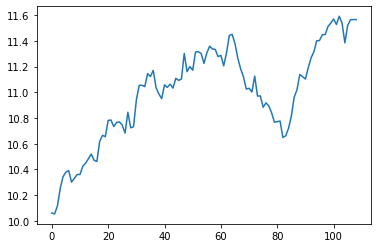

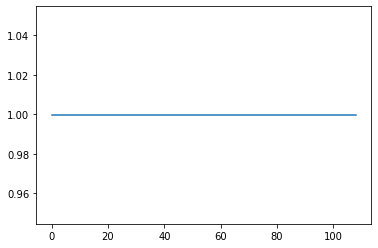

In [ ]:
obs = env.reset()
done = False
step = 0
prices_, actions_ = [], []
while not done:
  action = ddpg.get_action(obs, test=True)
  next_obs, reward, done, _ = env.step(action)
  obs = next_obs
  step += 1
  # print(step, obs, action)
  prices_.append(obs[0])
  actions_.append(action)
plt.plot(prices_)
plt.show()
plt.plot(actions_)
plt.show()